In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [19]:
x_train = pd.read_csv(
  "../data/processed/x_train.csv", index_col=0, dtype=str
).reset_index(drop=True)
x_test = pd.read_csv(
  "../data/processed/x_test.csv", index_col=0, dtype=str
).reset_index(drop=True)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

In [21]:
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_test = x_test[numeric_cols]

In [22]:
scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_train_x = scaler.transform(rel_x_train)
scaled_test_x = scaler.transform(rel_x_test)

In [24]:
best_preds = np.loadtxt("../data/predictions/rf_preds.csv")

In [25]:
resids = y_test - best_preds

In [26]:
# Take 10% most incorrect predictions
top10_pct_off = np.argsort(
  np.abs(np.array(resids))
)[-int(0.1 * len(resids))::][::-1]
extreme_resids = resids[top10_pct_off]
extreme_x = x_test.iloc[top10_pct_off, :]
extreme_y = y_test[top10_pct_off]

In [27]:
pd.merge(
  (
    extreme_x.deenergize_time.dt.date.value_counts() /
    extreme_x.deenergize_time.dt.date.value_counts().sum()
  ),
  (
    x_test.deenergize_time.dt.date.value_counts() / 
    x_test.deenergize_time.dt.date.value_counts().sum()
  ),
  how='outer', left_index=True, right_index=True
).sort_values('deenergize_time_x', ascending=False)

,deenergize_time_x,deenergize_time_y
2019-10-26,0.564103,0.305344
2019-10-09,0.179487,0.188295
2019-10-27,0.051282,0.012723
2020-10-25,0.051282,0.162850
2021-01-19,0.051282,0.007634
2020-09-07,0.025641,0.022901
2020-09-08,0.025641,0.020356
2020-10-26,0.025641,0.002545
2021-08-17,0.025641,0.061069
2018-10-14,NaN,0.010178


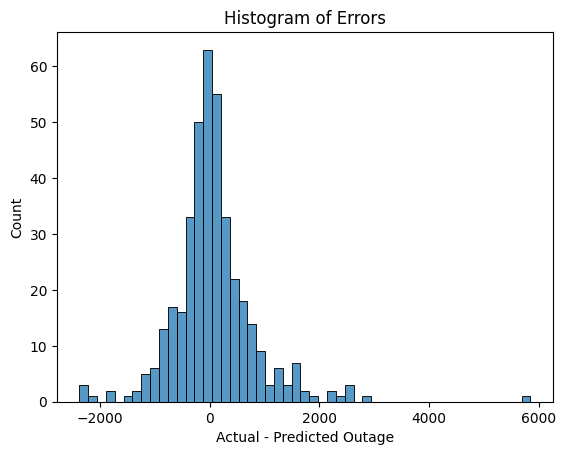

In [12]:
sns.histplot(resids)
plt.title("Histogram of Errors")
plt.xlabel("Actual - Predicted Outage")
plt.show()